In [537]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

import pandas_profiling
from feature_selector import FeatureSelector

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import math

import catboost
from catboost import Pool, cv

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# 1. EDA

In [173]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

feature-0  feature-1  feature-2  feature-3   feature-4   feature-5  \
0  37.977273   6.758452   3.636364  10.792929  160.801682  151.109783   
1  19.408163   5.933978   2.816327   5.877551  162.949911   76.153796   
2  40.265306   7.425645   3.734694  13.160998  172.099640  161.790879   
3  43.976744   7.648293   3.837209  14.392765  168.885456  175.277251   
4  24.320988   6.534011   3.567901   8.913580  163.076959   96.019681   

   feature-6  feature-7  feature-8  feature-9 ...   feature-1515  \
0   1.791689   6.818675   8.138413   8.270161 ...       5.658393   
1   1.381401   6.002651   5.080499   7.514421 ...       4.830811   
2   1.603976   7.410120  10.114794   8.805738 ...       6.397659   
3   1.622298   7.629033  12.180817   9.070719 ...       5.879135   
4   1.380679   6.566695   4.417010   8.058783 ...       8.148663   

   feature-1516  feature-1517  feature-1518  feature-1519  feature-1520  \
0      4.151040      4.540632      4.953183      5.351562      5.311048   
1      3.817712      4.123094      4.426343      4.823804      4.652173   
2      4.223177      4.685597      5.116870      5.333926      5.504569   
3      4.280132      4.563045      5.007714      5.159773      5.393628   
4      4.624973      5.173321      5.720312      6.259342      6.626469   

   feature-1521  feature-1522  feature-1523    y  
0      5.560922      5.643015      5.715999  0.0  
1      4.795274      4.860781      5.001426  0.0  
2      5.797956      6.009581      6.200889  0.0  
3      5.640132      5.472271      5.741399  0.0  
4      7.062406      7.472998      7.829842  0.0  

[5 rows x 1525 columns]

In [4]:
df.shape

(1105, 1525)

In [ ]:
profileReport = df.profile_report()

In [185]:
#profileReport
#This is the useful tool which can help to see different correlations and distributions of the dataset.
#But it takes very long time to run and there can be issues with memory. So run it carefully!

In [182]:
prof_rep_rej = profileReport.get_rejected_variables(threshold=0.95)

In [193]:
prof_rep_rej

['feature-1024',
 'feature-1030',
 'feature-1031',
 'feature-1033',
 'feature-1034',
 'feature-1035',
 'feature-1048',
 'feature-105',
 'feature-1050',
 'feature-1051',
 'feature-1052',
 'feature-1053',
 'feature-1054',
 'feature-1065',
 'feature-107',
 'feature-1081',
 'feature-1095',
 'feature-1096',
 'feature-1097',
 'feature-1098',
 'feature-1099',
 'feature-1100',
 'feature-1101',
 'feature-1102',
 'feature-1103',
 'feature-1104',
 'feature-1106',
 'feature-1107',
 'feature-1108',
 'feature-1109',
 'feature-1110',
 'feature-1111',
 'feature-1112',
 'feature-1113',
 'feature-1114',
 'feature-1116',
 'feature-1117',
 'feature-1118',
 'feature-1119',
 'feature-1120',
 'feature-1121',
 'feature-1122',
 'feature-1123',
 'feature-1124',
 'feature-1127',
 'feature-1128',
 'feature-1129',
 'feature-1130',
 'feature-1133',
 'feature-1134',
 'feature-1135',
 'feature-1137',
 'feature-1138',
 'feature-1139',
 'feature-1140',
 'feature-1141',
 'feature-1142',
 'feature-1143',
 'feature-1144',

In [6]:
X, y = df.drop(columns='y'), df['y']

In [194]:
#Will also store dataframe without rejected (highly correlated or constant) variables.
#Will compare some methods with and without these variables
X_prof_rep = X.drop(columns=prof_rep_rej)

# 2. Evaluating different feature selection techniques

## 2.1 FeatureSelector library (Gradient boosting + correlation e.t.c)

0 features with greater than 0.96 missing values.

128 features with a single unique value.

512 features with a correlation magnitude greater than 0.98.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's auc: 0.959922	valid_0's binary_logloss: 0.231947
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[60]	valid_0's auc: 0.910954	valid_0's binary_logloss: 0.316407
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[47]	valid_0's auc: 0.90844	valid_0's binary_logloss: 0.381327
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[13]	valid_0's auc: 0.942572	valid_0's binary_logloss: 0.395929
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[79]	valid_0's auc: 0.93438	valid_0's binary_logloss: 0.300045
Tra

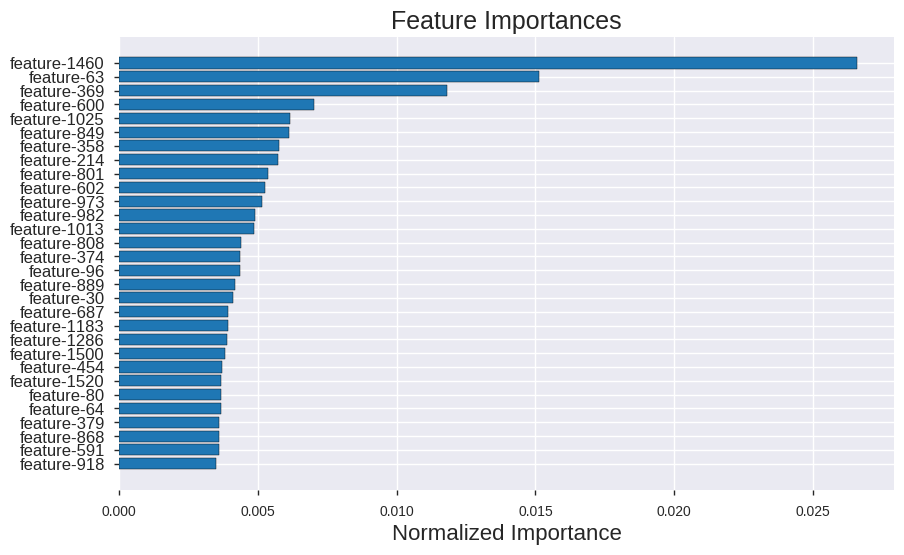

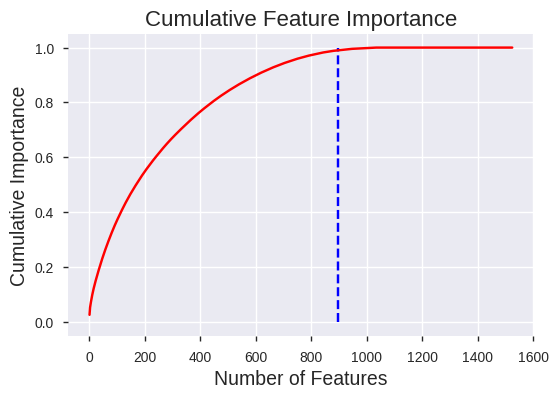

896 features required for 0.99 of cumulative importance


In [7]:
fs = FeatureSelector(data = X, labels = y)

fs.identify_all(selection_params = {'missing_threshold': 0.96, 'correlation_threshold': 0.98, 
                                    'task': 'classification', 'eval_metric': 'auc', 
                                     'cumulative_importance': 0.99})
fs.plot_feature_importances(threshold = 0.99, plot_n = 30)

In [9]:
X_fs = fs.remove(methods = 'all')

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 822 features.


## 2.2 Random Forest

In [219]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 500))
sel.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [220]:
X_rf = X.columns[(sel.get_support())]

In [221]:
X_rf

Index(['feature-0', 'feature-1', 'feature-4', 'feature-5', 'feature-6',
       'feature-7', 'feature-8', 'feature-9', 'feature-10', 'feature-11',
       ...
       'feature-1505', 'feature-1509', 'feature-1515', 'feature-1517',
       'feature-1518', 'feature-1519', 'feature-1520', 'feature-1521',
       'feature-1522', 'feature-1523'],
      dtype='object', length=444)

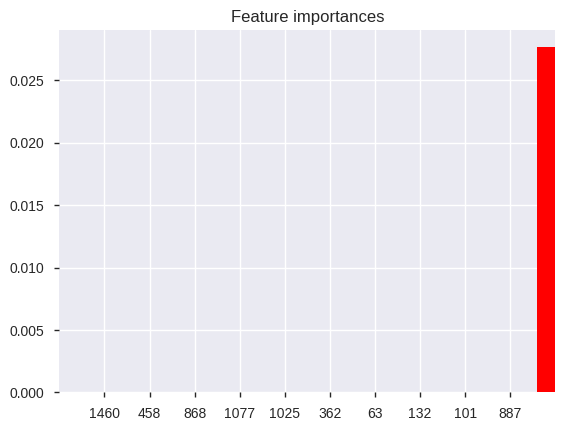

In [222]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[:10:-1]
# X is the train data used to fit the model 
plt.figure()
plt.title("Feature importances")
plt.bar(10, importances[indices],
       color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

In [203]:
sel_prof_rep = SelectFromModel(RandomForestClassifier(n_estimators = 500))
sel_prof_rep.fit(X_prof_rep, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
  

In [205]:
X_rf_prof_rep = X_prof_rep.columns[(sel_prof_rep.get_support())]

In [206]:
X_rf_prof_rep

Index(['feature-0', 'feature-1', 'feature-3', 'feature-4', 'feature-6',
       'feature-7', 'feature-8', 'feature-9', 'feature-10', 'feature-11',
       ...
       'feature-1325', 'feature-1386', 'feature-1458', 'feature-1460',
       'feature-1465', 'feature-1468', 'feature-1471', 'feature-1500',
       'feature-1505', 'feature-1515'],
      dtype='object', length=289)

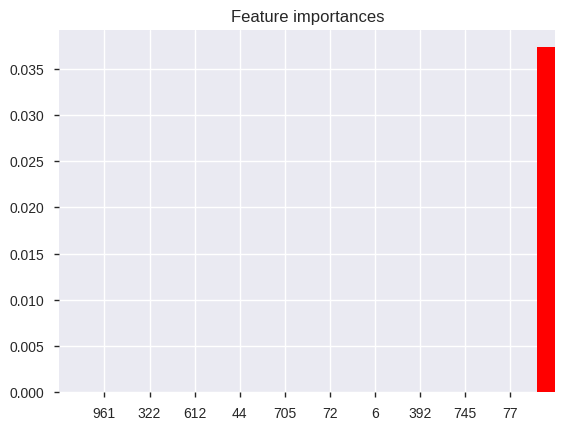

In [215]:
importances = sel_prof_rep.estimator_.feature_importances_
indices = np.argsort(importances)[:10:-1]
# X is the train data used to fit the model 
plt.figure()
plt.title("Feature importances")
plt.bar(10, importances[indices],
       color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

In [ ]:
importances

In [218]:
np.mean(importances)

0.001001001001001001

## 2.3 DFS

In [236]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify=y)

X_test, X_valid, y_test, y_valid = train_test_split(X_test_val, y_test_val, stratify=y_test_val)

In [409]:
#data with only pandas profiling columns
X_train_pp, X_test_val_pp, y_train_pp, y_test_val_pp = train_test_split(X_prof_rep, y, stratify=y)

X_test_pp, X_valid_pp, y_test_pp, y_valid_pp = train_test_split(X_test_val_pp, y_test_val_pp, stratify=y_test_val_pp)

In [237]:
batch_size = 32

train_tensor = TensorDataset(torch.Tensor(np.array(X_train)),
                             torch.from_numpy(np.array(y_train, dtype=np.int64))) 
train_loader = DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

valid_tensor = TensorDataset(torch.Tensor(np.array(X_valid)),
                             torch.from_numpy(np.array(y_valid, dtype=np.int64))) 
valid_loader = DataLoader(dataset = valid_tensor, batch_size = batch_size, shuffle = True)

test_tensor = TensorDataset(torch.Tensor(np.array(X_test)),
                             torch.from_numpy(np.array(y_test, dtype=np.int64))) 
test_loader = DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [410]:
train_tensor_pp = TensorDataset(torch.Tensor(np.array(X_train_pp)),
                             torch.from_numpy(np.array(y_train_pp, dtype=np.int64))) 
train_loader_pp = DataLoader(dataset = train_tensor_pp, batch_size = batch_size, shuffle = True)

valid_tensor_pp = TensorDataset(torch.Tensor(np.array(X_valid_pp)),
                             torch.from_numpy(np.array(y_valid_pp, dtype=np.int64))) 
valid_loader_pp = DataLoader(dataset = valid_tensor_pp, batch_size = batch_size, shuffle = True)

test_tensor_pp = TensorDataset(torch.Tensor(np.array(X_test_pp)),
                             torch.from_numpy(np.array(y_test_pp, dtype=np.int64))) 
test_loader_pp = DataLoader(dataset = test_tensor_pp, batch_size = batch_size, shuffle = True)

In [411]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [412]:
#Custom one-to-one layer for feature selection. There is no bias as it is noted in paper
class InputLayer(nn.Module):
    def __init__(self, in_features):
        super(InputLayer, self).__init__()
        self.in_features = in_features
        self.weight = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self.weight)

    def forward(self, input):
        repeated_weight = self.weight.repeat(self.in_features, 1)
        return F.linear(input, repeated_weight)


In [538]:
class MLP_DFS(nn.Module):
    def __init__(self, n_features, enc_sizes, act_funcs):
        super(MLP_DFS, self).__init__()
        self.input_layer = InputLayer(n_features)
        hidden_layers = [nn.Sequential(nn.Linear(in_f, out_f), act_func) 
                       for in_f, out_f, act_func in zip(enc_sizes, enc_sizes[1:], act_funcs)]
        self.layers = nn.Sequential(*hidden_layers)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.layers(x)
        return x

enc_sizes = [len(X.columns), 256, 128, 64, 2]
act_funcs = [nn.Tanh(), nn.Tanh(), nn.Tanh(), nn.Softmax(dim=0)]
model = MLP_DFS(len(X.columns), enc_sizes, act_funcs)
print(model)

MLP_DFS(
  (input_layer): InputLayer()
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1524, out_features=256, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=2, bias=True)
      (1): Softmax()
    )
  )
)


In [539]:
def train(model, train_loader, valid_loader):
    n_epochs = 10
    loss_fn = nn.NLLLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    lambda1 = 0.1
    lambda2 = 0.4
    alpha1 = 0.001
    alpha2 = 0.8
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=5, verbose=True)


    def calculateLoss(data_loss):
        L1_input=abs(model.input_layer.weight).sum()
        L2_input=(model.input_layer.weight **2).sum()
        L1s=[]
        L2_sqrs=[]

        for i in range(len(enc_sizes)-1):
            L1s.append (abs(model.layers[i][0].weight).sum())
            L2_sqrs.append((model.layers[i][0].weight ** 2).sum())

        L1 = torch.sum(torch.Tensor(L1s))
        L2_sqr = torch.sum(torch.Tensor(L2_sqrs))

        return data_loss + lambda1*(1.0-lambda2)*0.5*L2_input \
         + lambda1*lambda2*L1_input \
         + alpha1*(1.0-alpha2)*0.5 * L2_sqr + alpha1*alpha2 * L1  #Regularisation technique from paper



    for epoch in range(n_epochs):
        train_loss = 0.0
        model.train() # prep model for training

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            data_loss = loss_fn(output, target)

            loss = calculateLoss(data_loss)

            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())


        model.eval() #prep model for evaluation
        for data, target in valid_loader:

            output = model(data)
            data_loss = loss_fn(output, target)

            loss = calculateLoss(data_loss)

            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

In [540]:
train(model, train_loader, valid_loader)

[ 0/10] train_loss: 46.78512 valid_loss: 41.95712
Validation loss decreased (inf --> 41.957119).  Saving model ...
[ 1/10] train_loss: 37.98122 valid_loss: 33.93853
Validation loss decreased (41.957119 --> 33.938534).  Saving model ...
[ 2/10] train_loss: 30.62672 valid_loss: 27.27064
Validation loss decreased (33.938534 --> 27.270641).  Saving model ...
[ 3/10] train_loss: 24.53369 valid_loss: 21.76119
Validation loss decreased (27.270641 --> 21.761192).  Saving model ...
[ 4/10] train_loss: 19.51009 valid_loss: 17.24707
Validation loss decreased (21.761192 --> 17.247072).  Saving model ...
[ 5/10] train_loss: 15.43506 valid_loss: 13.61431
Validation loss decreased (17.247072 --> 13.614309).  Saving model ...
[ 6/10] train_loss: 12.16882 valid_loss: 10.73451
Validation loss decreased (13.614309 --> 10.734512).  Saving model ...
[ 7/10] train_loss: 9.62473 valid_loss: 8.53652
Validation loss decreased (10.734512 --> 8.536523).  Saving model ...
[ 8/10] train_loss: 7.72506 valid_loss: 6

In [541]:
model.input_layer.weight

Parameter containing:
tensor([-0.0012,  0.0018,  0.0015,  ...,  0.0006,  0.0008,  0.0014],
       requires_grad=True)

In [542]:
selected = (abs(model.input_layer.weight)>torch.max(abs(model.input_layer.weight))*0.05).numpy().astype(bool)

In [543]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [544]:
selected

array([False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False, False,  True,  True, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False,  True, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False,  True,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False,

In [545]:
dfs_sel_columns = np.array(X.columns)[selected]

In [546]:
weight_data = pd.DataFrame(data = {"feat":dfs_sel_columns, "weight":abs(model.input_layer.weight.detach().numpy()[selected])})

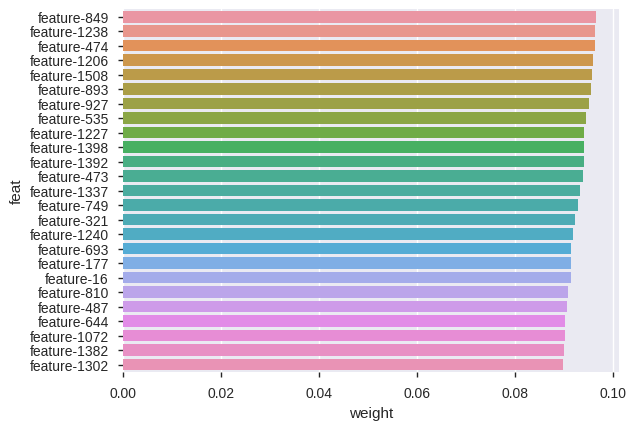

In [547]:
sns.barplot(x="weight", y="feat", data=weight_data.nlargest(25, 'weight'))

In [548]:
len(dfs_sel_columns)

336

In [523]:
#Doing the same but only after rejecting highly correlated columns (after pandas-profiling)
enc_sizes = [len(X_prof_rep.columns), 256, 128, 64, 2]
act_funcs = [nn.Tanh(), nn.Tanh(), nn.Tanh(), nn.Tanh(), nn.Softmax(dim=0)]
model_pp = MLP_DFS(len(X_prof_rep.columns), enc_sizes, act_funcs)
train(model_pp, train_loader_pp, valid_loader_pp)

[ 0/10] train_loss: 30.24033 valid_loss: 27.03780
Validation loss decreased (inf --> 27.037797).  Saving model ...
[ 1/10] train_loss: 24.45946 valid_loss: 21.83196
Validation loss decreased (27.037797 --> 21.831957).  Saving model ...
[ 2/10] train_loss: 19.67627 valid_loss: 17.49130
Validation loss decreased (21.831957 --> 17.491295).  Saving model ...
[ 3/10] train_loss: 15.71837 valid_loss: 13.92563
Validation loss decreased (17.491295 --> 13.925629).  Saving model ...
[ 4/10] train_loss: 12.47185 valid_loss: 11.00567
Validation loss decreased (13.925629 --> 11.005675).  Saving model ...
[ 5/10] train_loss: 9.83559 valid_loss: 8.66380
Validation loss decreased (11.005675 --> 8.663796).  Saving model ...
[ 6/10] train_loss: 7.74161 valid_loss: 6.82623
Validation loss decreased (8.663796 --> 6.826230).  Saving model ...
[ 7/10] train_loss: 6.11744 valid_loss: 5.42248
Validation loss decreased (6.826230 --> 5.422480).  Saving model ...
[ 8/10] train_loss: 4.90756 valid_loss: 4.41727
V

In [524]:
selected_pp = (abs(model_pp.input_layer.weight)>torch.max(abs(model_pp.input_layer.weight))*0.05).numpy().astype(bool)

In [525]:
dfs_pp_sel_columns = np.array(X_prof_rep.columns)[selected_pp]

In [526]:
weight_data_pp = pd.DataFrame(data = {"feat":dfs_pp_sel_columns, "weight":abs(model_pp.input_layer.weight.detach().numpy()[selected_pp])})

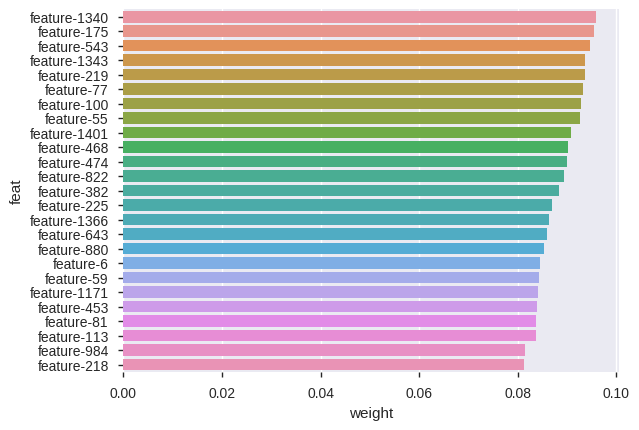

In [527]:
sns.barplot(x="weight", y="feat", data=weight_data_pp.nlargest(25, 'weight'))

In [528]:
len(weight_data_pp)

180

In [529]:
dfs_pp_sel_columns

array(['feature-1', 'feature-6', 'feature-9', 'feature-10', 'feature-30',
       'feature-41', 'feature-43', 'feature-52', 'feature-55',
       'feature-59', 'feature-61', 'feature-68', 'feature-77',
       'feature-81', 'feature-89', 'feature-100', 'feature-108',
       'feature-111', 'feature-113', 'feature-118', 'feature-123',
       'feature-127', 'feature-147', 'feature-149', 'feature-161',
       'feature-163', 'feature-164', 'feature-166', 'feature-168',
       'feature-170', 'feature-172', 'feature-175', 'feature-187',
       'feature-198', 'feature-199', 'feature-218', 'feature-219',
       'feature-222', 'feature-225', 'feature-227', 'feature-282',
       'feature-297', 'feature-299', 'feature-305', 'feature-308',
       'feature-313', 'feature-315', 'feature-321', 'feature-324',
       'feature-341', 'feature-350', 'feature-352', 'feature-366',
       'feature-369', 'feature-380', 'feature-382', 'feature-396',
       'feature-399', 'feature-406', 'feature-415', 'feature-429'

# Comparing results on different ML models

## NaiveBayes

In [530]:
br = BernoulliNB()

In [549]:
nb_dict = {'all_columns':np.mean(cross_val_score(br, X_train, y_train, cv=5, scoring = make_scorer(f1_score))),
           'pandas-profiling':np.mean(cross_val_score(br, X_train[X_prof_rep.columns], y_train, cv=5, scoring = make_scorer(f1_score))),
           'featureSelector':np.mean(cross_val_score(br, X_train[X_fs.columns], y_train, cv=5, scoring = make_scorer(f1_score))), 
           'Random Forest':np.mean(cross_val_score(br, X_train[X_rf], y_train, cv=5, scoring = make_scorer(f1_score))), 
           'Random Forest w Pandas Profiler':np.mean(cross_val_score(br, X_train[X_rf_prof_rep], y_train, cv=5, scoring = make_scorer(f1_score))), 
           'DFS':np.mean(cross_val_score(br, X_train[dfs_sel_columns], y_train, cv=5, scoring = make_scorer(f1_score))),
           'DFS w PP':np.mean(cross_val_score(br, X_train[dfs_pp_sel_columns], y_train, cv=5, scoring = make_scorer(f1_score)))}

In [550]:
nb_data = pd.DataFrame(data=list(nb_dict.items()), columns=['Method', 'Mean F1-score'])

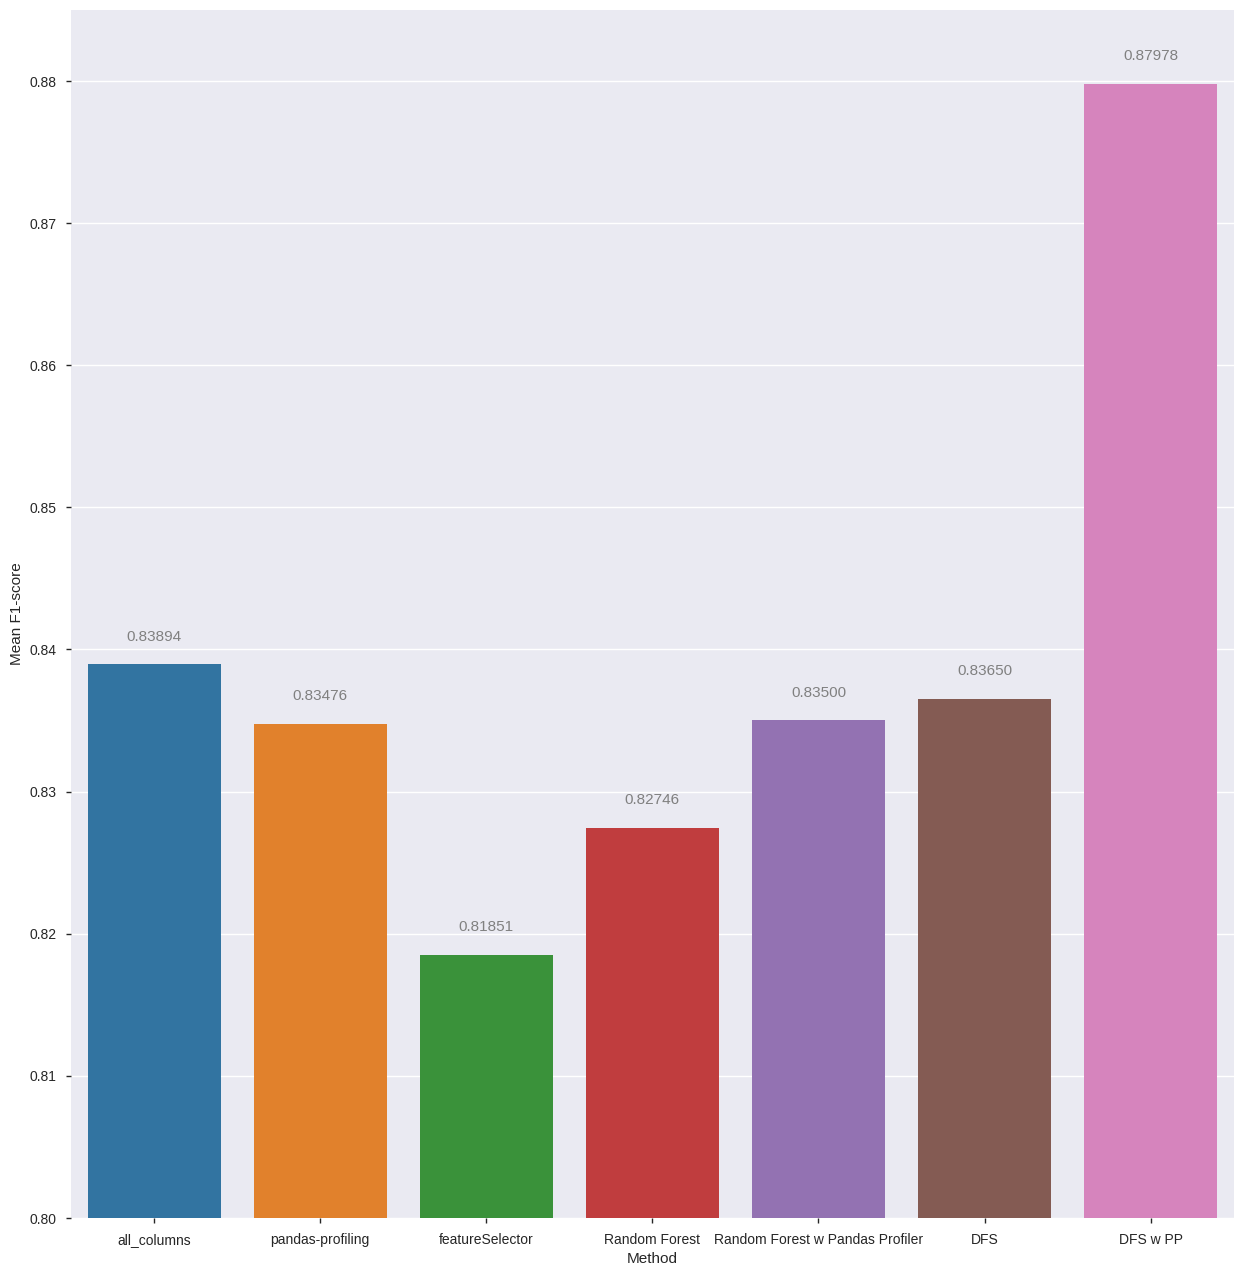

In [511]:
plt.figure(figsize=(15,16))
g = sns.barplot(x = 'Method', y='Mean F1-score', data = nb_data)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.5f" % p.get_height(),(p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0.8,0.885) #To make space for the annotations

## Logistic Regression

In [394]:
lr = LogisticRegression(solver='liblinear', max_iter=1000)

In [395]:
lr_dict = {'all_columns':np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring = make_scorer(f1_score))),
           'pandas-profiling':np.mean(cross_val_score(lr, X_train[X_prof_rep.columns], y_train, cv=5, scoring = make_scorer(f1_score))),
           'featureSelector':np.mean(cross_val_score(lr, X_train[X_fs.columns], y_train, cv=5, scoring = make_scorer(f1_score))), 
           'Random Forest':np.mean(cross_val_score(lr, X_train[X_rf], y_train, cv=5, scoring = make_scorer(f1_score))), 
           'Random Forest w Pandas Profiler':np.mean(cross_val_score(lr, X_train[X_rf_prof_rep], y_train, cv=5, scoring = make_scorer(f1_score))), 
           'DFS':np.mean(cross_val_score(lr, X_train[dfs_sel_columns], y_train, cv=5, scoring = make_scorer(f1_score))),
           'DFS w PP':np.mean(cross_val_score(lr, X_train[dfs_pp_sel_columns], y_train, cv=5, scoring = make_scorer(f1_score)))}

In [437]:
lr_data = pd.DataFrame(data=list(lr_dict.items()), columns=['Method', 'Mean F1-score'])

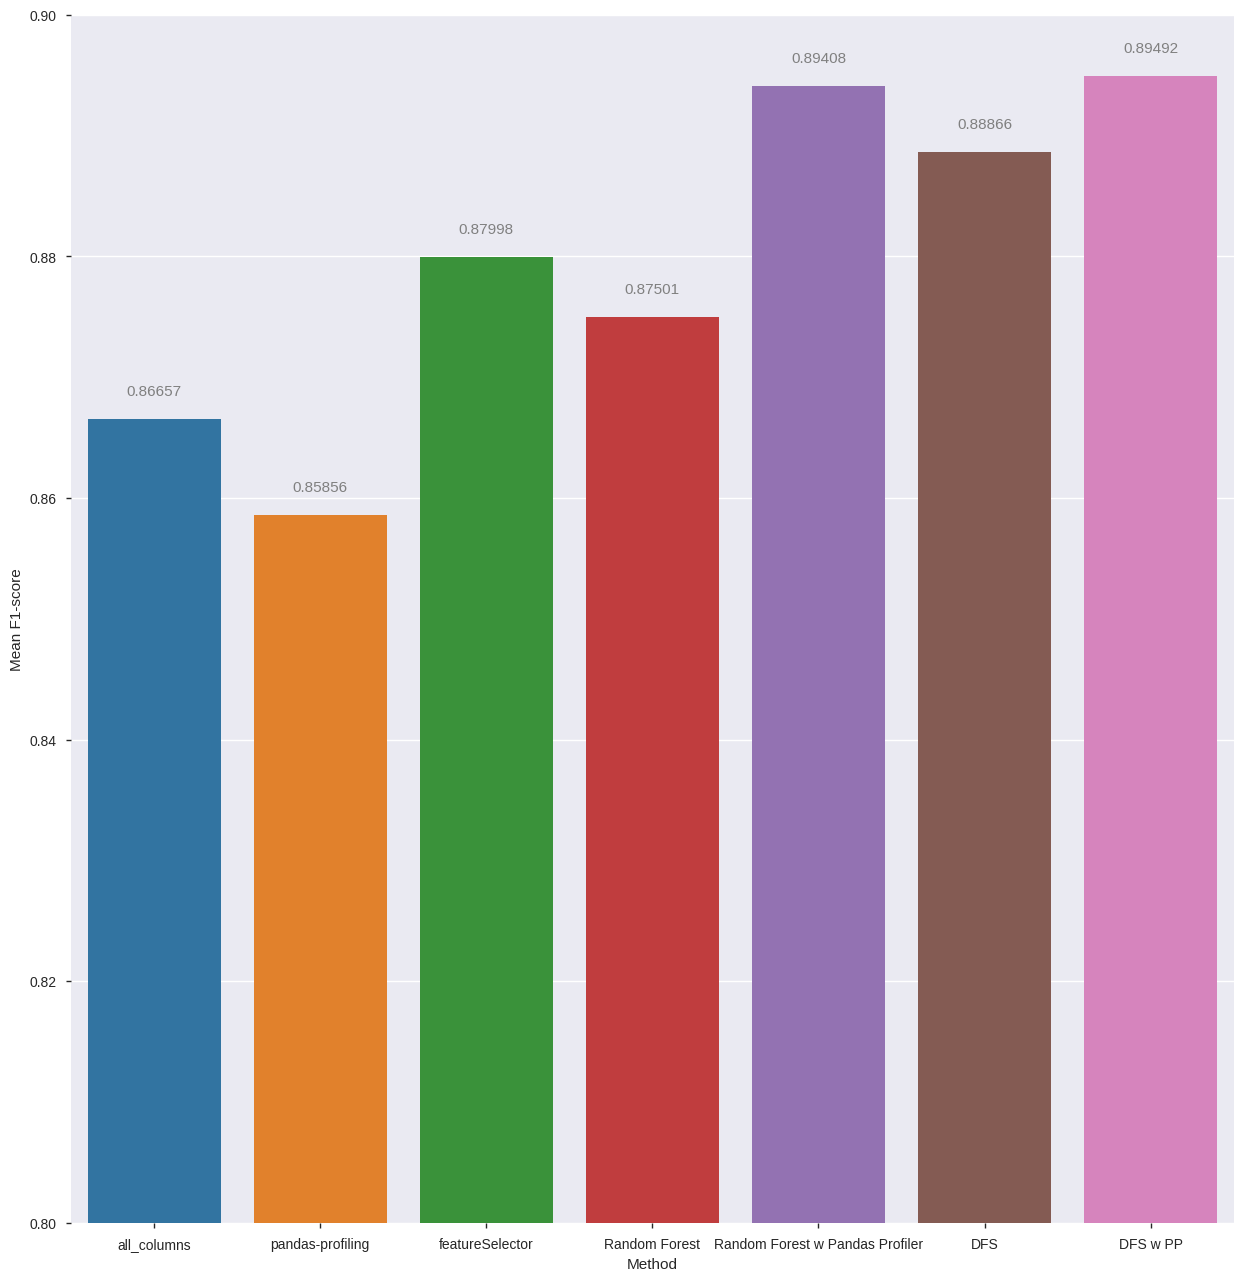

In [438]:
plt.figure(figsize=(15,16))
g = sns.barplot(x = 'Method', y='Mean F1-score', data = lr_data)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.5f" % p.get_height(),(p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0.8,0.9) #To make space for the annotations

## Catboost

In [443]:
cv_dataset = Pool(data=X_train,
                  label=y_train)

params = {"iterations": 15,
          "depth": 7,
          "learning_rate":0.1,
          "loss_function": "Logloss",
          "leaf_estimation_iterations":30,
          "rsm":0.8,
          "reg_lambda":0.1,
          "random_strength":0.123,
          "eval_metric":"F1",
          "loss_function":'Logloss',
          "verbose": False}

scores_all_cols = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [446]:
scores_all_cols['test-F1-mean'].max()

0.9276246794507331

In [447]:
cv_dataset = Pool(data=X_train[X_prof_rep.columns],
                  label=y_train)

scores_pandas_prof = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [448]:
scores_pandas_prof['test-F1-mean'].max()

0.9149816855587085

In [454]:
cv_dataset = Pool(data=X_train[X_fs.columns],
                  label=y_train)

scores_feature_selector = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [455]:
scores_feature_selector['test-F1-mean'].max()

0.9169225979656003

In [456]:
cv_dataset = Pool(data=X_train[X_rf],
                  label=y_train)

params['iterations'] = 30

scores_rf = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [457]:
scores_rf['test-F1-mean'].max()

0.9248436906973492

In [484]:
cv_dataset = Pool(data=X_train[X_rf_prof_rep],
                  label=y_train)

params['iterations'] = 30

scores_rf_pp = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [485]:
scores_rf_pp['test-F1-mean'].max()

0.9088025578156945

In [471]:
cv_dataset = Pool(data=X_train[dfs_sel_columns],
                  label=y_train)

scores_dfs = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [472]:
scores_dfs['test-F1-mean'].max()

0.9069099906478547

In [473]:
cv_dataset = Pool(data=X_train[dfs_pp_sel_columns],
                  label=y_train)

scores_dfs_pp = cv(cv_dataset,
            params,
            fold_count=3, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [474]:
scores_dfs_pp['test-F1-mean'].max()

0.9176521641319172

In [486]:
cb_dict = {'all_columns':scores_all_cols['test-F1-mean'].max(),
           'pandas-profiling':scores_pandas_prof['test-F1-mean'].max(),
           'featureSelector':scores_feature_selector['test-F1-mean'].max(), 
           'Random Forest':scores_rf['test-F1-mean'].max(), 
           'Random Forest w Pandas Profiler':scores_rf_pp['test-F1-mean'].max(), 
           'DFS':scores_dfs['test-F1-mean'].max(),
           'DFS w PP':scores_dfs_pp['test-F1-mean'].max()}

In [487]:
cb_data = pd.DataFrame(data=list(cb_dict.items()), columns=['Method', 'Mean F1-score'])

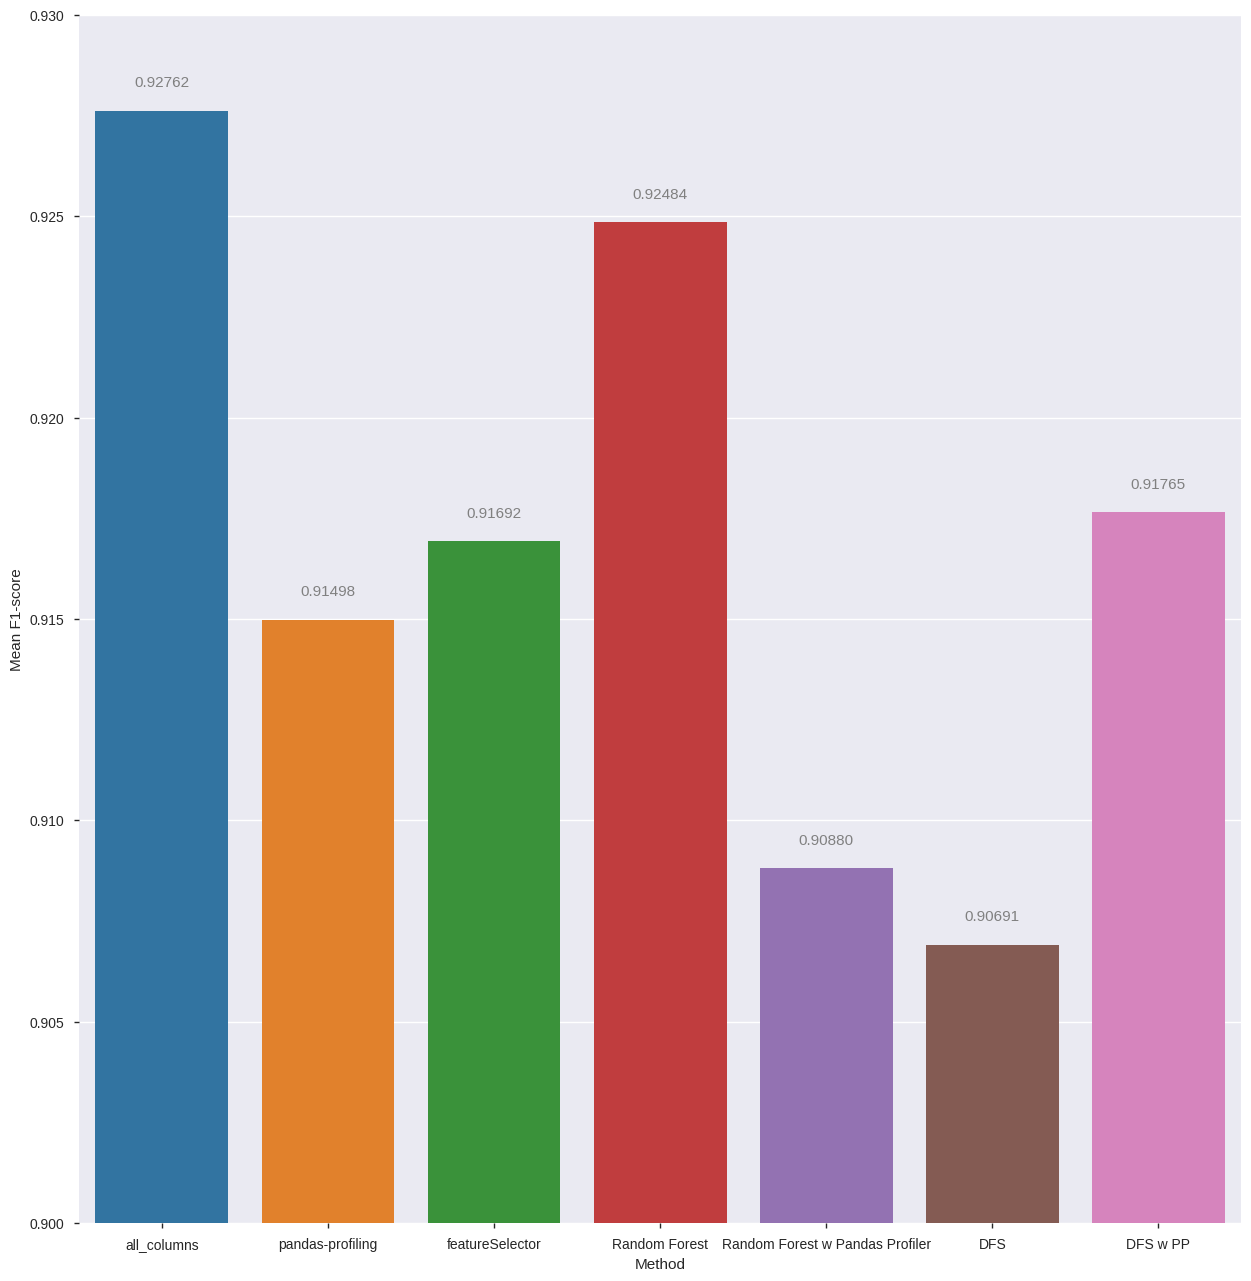

In [488]:
plt.figure(figsize=(15,16))
g = sns.barplot(x = 'Method', y='Mean F1-score', data = cb_data)
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.5f" % p.get_height(),(p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0.9,0.93) #To make space for the annotations

Заключение:
Были протестированы различные методы отбора признаков и проведено сравнение их результатов работы с реализованным на Pytorch методом DFS. Также для двух методов сравнивались результаты на чистом датасете и датасете с уже заранее отобранными сильно скоррелированными или константными признаками. Во всех случаях полученная при работе с датасетом после удаления скореллированных фич метрика была лучше. Также, на 2 методах из 3 результаты работы алгоритма с признаками, отобранными DFS показали лучший результат, чем все остальные алгоритмы.
Довольно странным показалось то, что почти у всех методах по крайней мере топовые признаки практически не пересекаются, однако результаты работы алгоритмов все равно показывают довольно близкие значения.